# Toy model evaluation of FE estimation and clustering 

In [1]:
import numpy as np
import toy_models
import GMM_FE
import matplotlib.pyplot as plt

In [2]:
toy_model = 'mGMMs'

x_lims = [[0,1],[0,1]]
stack_landscapes=False
# Create model
if toy_model == 'mGMMs':
    tm = toy_models.MultipleGMMs()
elif toy_model == 'moons':
    tm = toy_models.Moons()
    x_lims = [[-1.1,2.1],[-0.55,1.1]]
else:
    tm = toy_models.GMM2D()

nx = 25


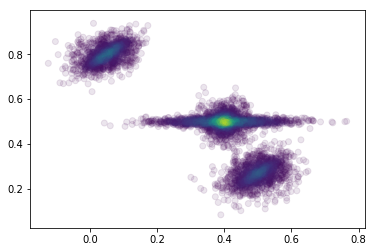

In [3]:
# Sample from model
data = tm.sample(6000)

# Compute true density at points
data_density = tm.density(data)

plt.figure(1)
plt.scatter(data[:,0],data[:,1],c=data_density,alpha=0.1)
plt.show()

Density grid shape: (25, 25)


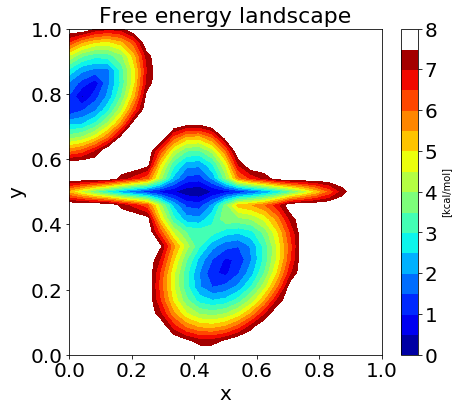

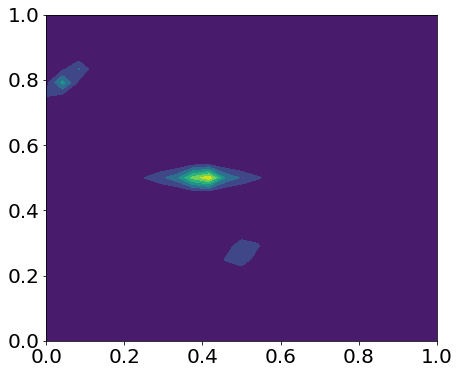

In [4]:
# Create a free energy object with known toy model
true_fe = GMM_FE.FreeEnergy(data,x_lims=x_lims,n_grids=nx,verbose=False,stack_landscapes=stack_landscapes)
true_fe.density_est_ = tm
coords, density = true_fe.density_landscape()

# Compute true free energy
FE_landscape = true_fe._free_energy(density)
min_FE = np.min(FE_landscape)
FE_landscape = FE_landscape-min_FE

FE_points = true_fe._free_energy(data_density)-min_FE

# Set true free energies
true_fe.coords_ = coords
true_fe.FE_landscape_ = FE_landscape
true_fe.FE_points_ = FE_points

# Visualize the model
true_fe.visualize(show_data=False)

plt.figure(2)
plt.contourf(coords[0],coords[1],np.exp(-FE_landscape/(true_fe.temperature_*true_fe.boltzmann_constant)))

In [5]:
# Cluster data
if hasattr(tm,"assign_cluster_labels"):
    labels = tm.assign_cluster_labels(data)
    true_fe.labels_=labels
else:
    #labels, cluster_centers = true_fe.cluster(coords,FE_points,data,assign_transition_points=True)
    labels, cluster_centers = true_fe.cluster(data,FE_points,assign_transition_points=False)


NameError: name 'cluster_centers' is not defined

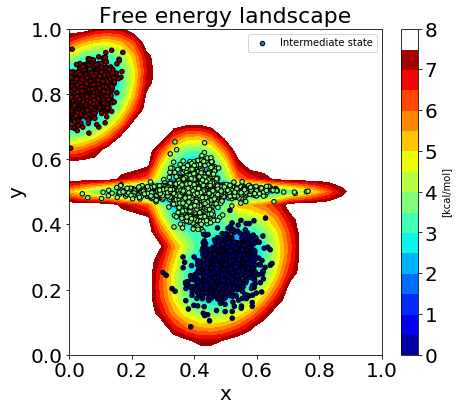

In [6]:
# Visualize true clusters
true_fe.visualize(show_data=True)
#plt.scatter(true_fe.cl_.grid_points_[:,0],true_fe.cl_.grid_points_[:,1],c=true_fe.is_FE_min)
print(cluster_centers)

In [7]:
# Estimate free energy and clustering with GMM and cross-validation
stack_landscapes = False

gmm_FE = GMM_FE.FreeEnergy(data,min_n_components=7,max_n_components=12, n_components_step=1, x_lims=true_fe.x_lims_, 
                           n_grids=true_fe.nx_, stack_landscapes=stack_landscapes, n_iterations=7, convergence_tol=1e-5, n_splits=1)

est_coords, est_FE_landscape, est_FE_points = gmm_FE.landscape()

*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 1
   shuffle_data = False
   n_iterations = 7
   n_grids = 25
   covergence_tol = 1e-05
   stack_landscapes = False
   x_lims (axes limits) = [[0, 1], [0, 1]]
   temperature = 300.0
   min_n_components = 7
   max_n_components = 12
   n_components_step = 1
*----------------------------------------------------------------------------*
Estimating density with GMM.
# Components = 7


/Users/annie/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


# Components = 8
# Components = 9
# Components = 10
# Components = 11
# Components = 12
Identifying final model with 8 components.
Evaluating density in landscape
Density grid shape: (25, 25)


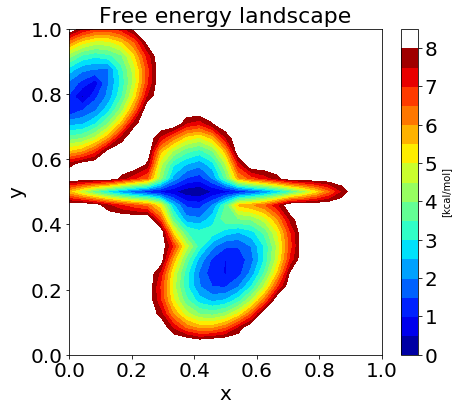

In [8]:
# Visualize estimated free energy landscape and the true free energy contours
gmm_FE.visualize(show_data=False,vmax=8,n_contour_levels=20)

if stack_landscapes:
    # Plot the model weights
    plt.figure(2)
    plt.plot(gmm_FE.density_est_.n_components_list_,gmm_FE.density_est_.model_weights_,linewidth=2,marker='o',color=[0.56,0.56,0.6],markersize=10)
    
    # Plot each indivudual model
    n_models = gmm_FE.density_est_.n_models_
    for i_model in range(n_models):
        # Create a free energy object with known toy model
        mod_fe = GMM_FE.FreeEnergy(data,x_lims=true_fe.x_lims_,n_grids=true_fe.nx_,verbose=False)
        mod_fe.density_est_ = gmm_FE.density_est_.GMM_list_[i_model]
        mod_coords, density = mod_fe.density_landscape()
        
        # Compute true free energy
        mod_FE_landscape = mod_fe._free_energy(density)
        mod_min_FE = np.min(mod_FE_landscape)
        mod_FE_landscape = mod_FE_landscape-mod_min_FE

        # Set true free energies
        mod_fe.coords_ = mod_coords
        mod_fe.FE_landscape_ = mod_FE_landscape

        # Visualize the model
        mod_fe.visualize(show_data=True)

In [10]:
# Cluster based on estimated density model
gmm_FE.stack_landscapes_ = False
est_labels, est_cluster_centers = gmm_FE.cluster(coords,est_FE_points,data,assign_transition_points=True)

Clustering free energy landscape...
Computing Hessians.
Constructing connected components.
# Graph connections: 8.0
Clustering data points.
Cluster labels: [0. 1. 2. 3.]
Assigning cluster indices to non-core cluster points.
Done clustering.


[5711 4855 1378]
[5711 4855 1378]
8


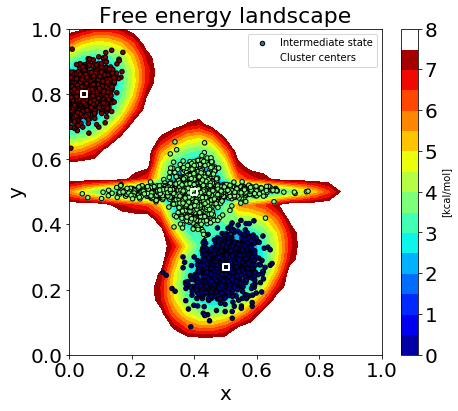

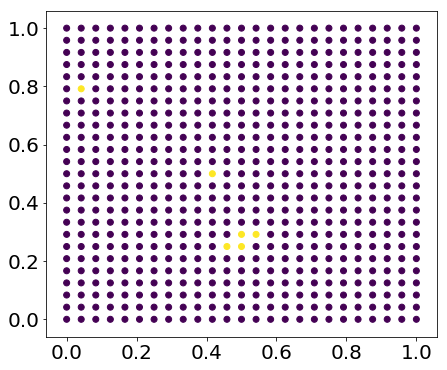

In [11]:
print(gmm_FE.cluster_centers_)
gmm_FE.visualize(show_data=True)
plt.figure(2)
plt.scatter(gmm_FE.cl_.grid_points_[:,0],gmm_FE.cl_.grid_points_[:,1],c=gmm_FE.is_FE_min)
print(est_cluster_centers)
if not(stack_landscapes):
    print(gmm_FE.density_est_.n_components_)

In [23]:
tm_eval = toy_models.MethodEvaluator(x_lims=[[0,1],[0,1]], convergence_tol=1e-4,toy_model=toy_model,verbose=False)
tm_eval.run_evaluation(10, 8000, n_iterations=3, min_n_components=7, max_n_components=18, n_splits=1)

Setting true model.
Density grid shape: (30, 30)
Run: 1/10
Estimating density with GMM.
Removing zero-weighted models.
Setting model weights: [0.33333333 0.33333333 0.33333333]
# components: [9, 9, 9]
Identifying final model with [9, 9, 9] components.
Evaluating density in landscape
Density grid shape: (30, 30)
Clustering free energy landscape...


AttributeError: 'LandscapeStacker' object has no attribute 'n_components_'

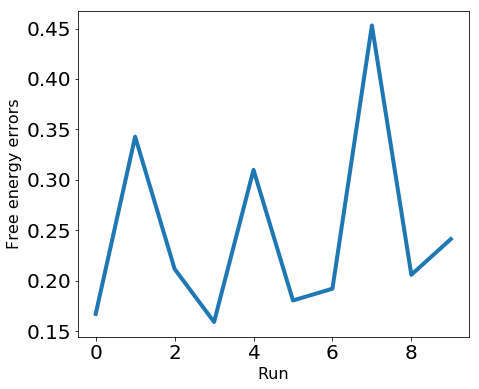

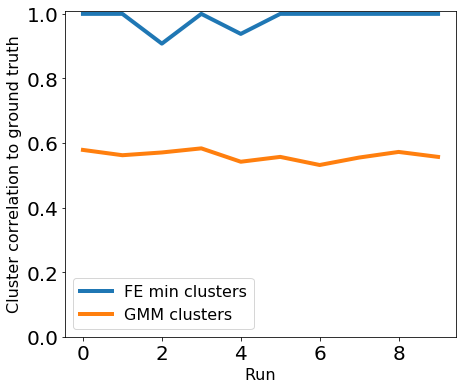

In [13]:
plt.figure(1)
plt.plot(tm_eval.FE_errors_GMM_CV_,linewidth=4)
plt.ylabel("Free energy errors",fontsize=16)
plt.xlabel("Run",fontsize=16)

plt.figure(2)
plt.plot(tm_eval.cluster_scores_GMM_CV_,label="FE min clusters",linewidth=4)
plt.plot(tm_eval.cluster_scores_GMM_clusters_,label="GMM clusters",linewidth=4)
plt.ylim([0,1.01])
plt.ylabel("Cluster correlation to ground truth",fontsize=16)
plt.xlabel("Run",fontsize=16)
plt.legend(fontsize=16)
